# Interaction Example
$$
X_1, X_2 \sim \mathcal{N}(\boldsymbol{0}, \Sigma^{-1}), \quad \Sigma = \left[\begin{array}{c}
    2 &\rho\\
    \rho & 2
\end{array}\right]\\
y = \min(X_1, X_2) - 0.1X_1 - 0.1X_2
$$

In [1]:
import time 
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import parameters_to_vector, vector_to_parameters

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import numpy as np
from LANAM.models import LaNAM, NAM, BayesianLinearRegression
from LANAM.config import *
from LANAM.trainer import *
from LANAM.trainer.nam_trainer import train
from LANAM.data import *

from LANAM.utils.plotting import * 
from LANAM.utils.output_filter import OutputFilter
from LANAM.utils.wandb import *

from laplace import Laplace
from laplace import marglik_training as lamt
from laplace.curvature.backpack import BackPackGGN

v3-nam, concurvity, concurvity regularization
v4-lanam, concurvity 
v5-nam, concurvity, l1 regularization
v6-nam, sin3x, l1 regularization 
v7-lanam, sin3x, concurvity regularization 
v8-nam, concurvity, patience=10

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
def generate_interaction_example(rho, min_max=True): 
    # rho = 0, 0.7, 0.9, 0.95, 0.99
    data = interaction_example(rho=rho, min_max=min_max)


    input_0, input_1 = data.features.T
    target = data.targets
    
    plt.figure(figsize=(4, 4))
    plt.scatter(input_0, input_1)
    plt.xlabel('input_0')
    plt.ylabel('input_1')
    plot_3d(input_0, input_1, target)
    
    return data

[Epoch=100, Train_RMSE:  0.800, Train_R_perp:  0.043, Val_RMSE:  0.278, Val_R_perp:  0.000, n_hypersteps=99]: observed noise= 0.460, prior precision=tensor([2.4899e+00, 3.0710e+03])
[Epoch=200, Train_RMSE:  0.800, Train_R_perp:  0.106, Val_RMSE:  0.279, Val_R_perp:  0.005, n_hypersteps=99]: observed noise= 0.462, prior precision=tensor([2.2623e+00, 2.8045e+03])
[Epoch=300, Train_RMSE:  0.799, Train_R_perp:  0.039, Val_RMSE:  0.278, Val_R_perp:  0.007, n_hypersteps=99]: observed noise= 0.461, prior precision=tensor([2.3811e+00, 2.8712e+03])
[Epoch=400, Train_RMSE:  0.799, Train_R_perp:  0.073, Val_RMSE:  0.278, Val_R_perp:  0.001, n_hypersteps=99]: observed noise= 0.461, prior precision=tensor([2.3209e+00, 2.8362e+03])
MARGLIK: finished training. Recover best model and fit Laplace.


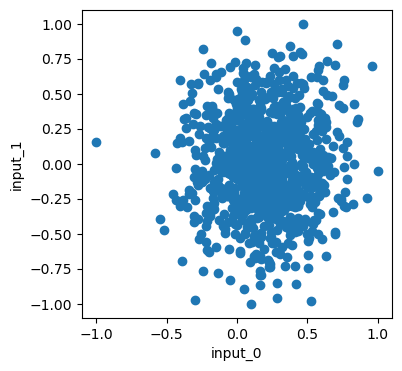

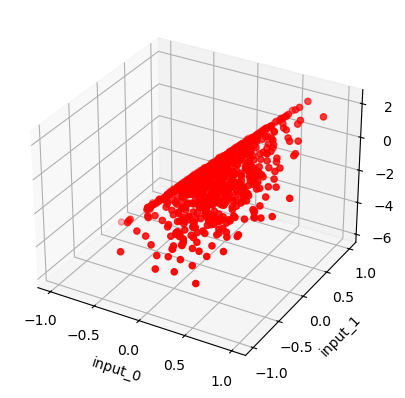

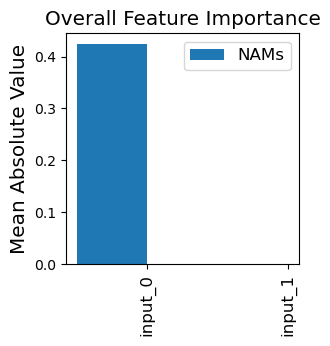

[Epoch=100, Train_RMSE:  0.517, Train_R_perp:  0.670, Val_RMSE:  0.148, Val_R_perp:  0.075, n_hypersteps=99]: observed noise= 0.300, prior precision=tensor([2.2070e+00, 3.9418e+03])
[Epoch=200, Train_RMSE:  0.521, Train_R_perp:  0.672, Val_RMSE:  0.148, Val_R_perp:  0.036, n_hypersteps=99]: observed noise= 0.301, prior precision=tensor([2.4788e+00, 3.1480e+03])
[Epoch=300, Train_RMSE:  0.518, Train_R_perp:  0.422, Val_RMSE:  0.147, Val_R_perp:  0.057, n_hypersteps=99]: observed noise= 0.299, prior precision=tensor([2.5901e+00, 3.1532e+03])
[Epoch=400, Train_RMSE:  0.518, Train_R_perp:  0.643, Val_RMSE:  0.151, Val_R_perp:  0.068, n_hypersteps=99]: observed noise= 0.299, prior precision=tensor([2.4356e+00, 3.8724e+03])
MARGLIK: finished training. Recover best model and fit Laplace.


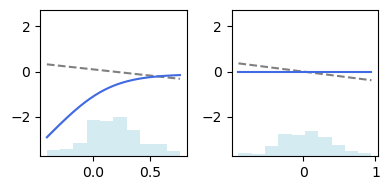

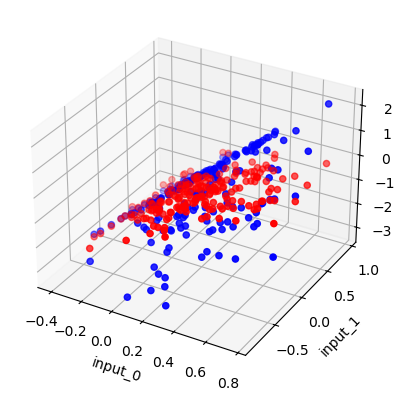

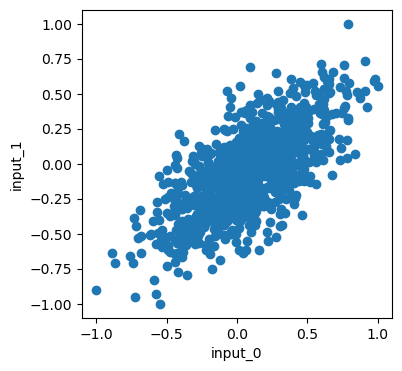

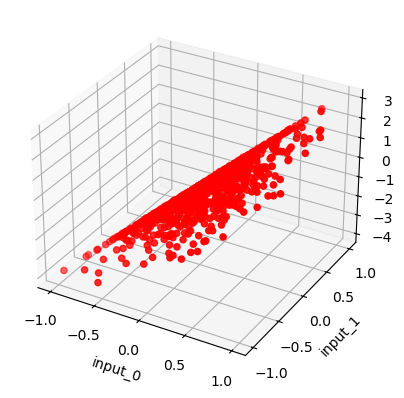

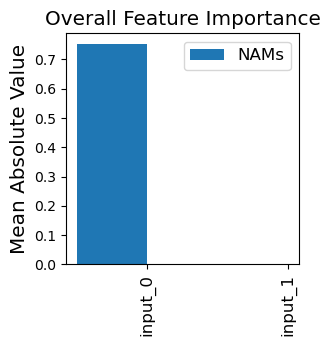

[Epoch=100, Train_RMSE:  0.301, Train_R_perp:  0.830, Val_RMSE:  0.104, Val_R_perp:  0.093, n_hypersteps=99]: observed noise= 0.173, prior precision=tensor([2.2249e+00, 4.1592e+03])
[Epoch=200, Train_RMSE:  0.299, Train_R_perp:  0.634, Val_RMSE:  0.098, Val_R_perp:  0.090, n_hypersteps=99]: observed noise= 0.173, prior precision=tensor([2.4190e+00, 2.6385e+03])
[Epoch=300, Train_RMSE:  0.302, Train_R_perp:  0.567, Val_RMSE:  0.100, Val_R_perp:  0.086, n_hypersteps=99]: observed noise= 0.174, prior precision=tensor([2.5913e+00, 4.8481e+03])
[Epoch=400, Train_RMSE:  0.298, Train_R_perp:  0.789, Val_RMSE:  0.097, Val_R_perp:  0.090, n_hypersteps=99]: observed noise= 0.172, prior precision=tensor([2.5388e+00, 2.9434e+03])
MARGLIK: finished training. Recover best model and fit Laplace.


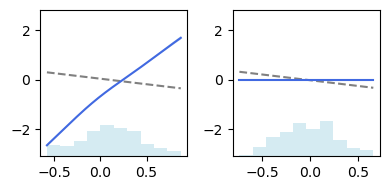

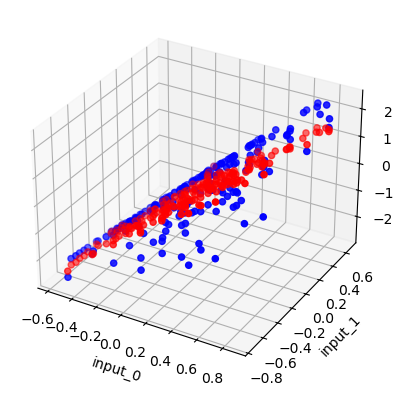

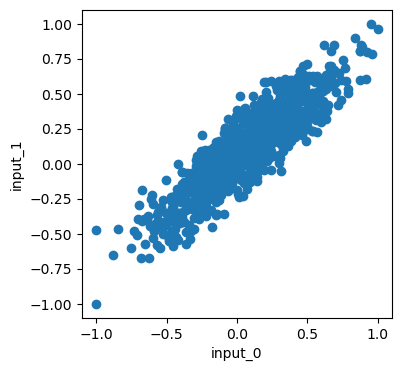

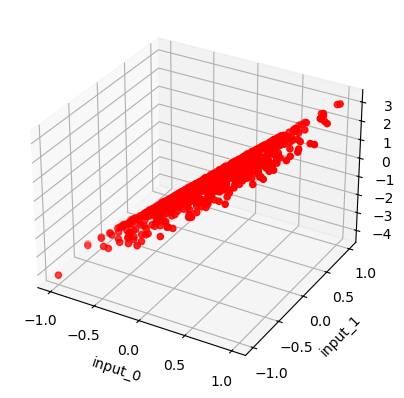

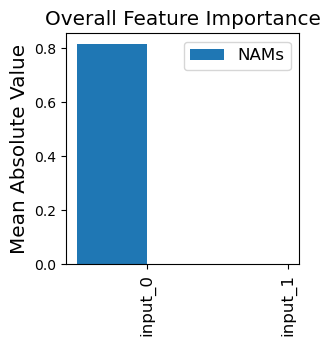

[Epoch=100, Train_RMSE:  0.249, Train_R_perp:  0.933, Val_RMSE:  0.078, Val_R_perp:  0.088, n_hypersteps=99]: observed noise= 0.142, prior precision=tensor([2.9484e+00, 3.5955e+03])
[Epoch=200, Train_RMSE:  0.231, Train_R_perp:  0.780, Val_RMSE:  0.071, Val_R_perp:  0.099, n_hypersteps=99]: observed noise= 0.133, prior precision=tensor([3.4473e+00, 3.4884e+03])
[Epoch=300, Train_RMSE:  0.233, Train_R_perp:  0.903, Val_RMSE:  0.073, Val_R_perp:  0.101, n_hypersteps=99]: observed noise= 0.135, prior precision=tensor([3.4860e+00, 4.2869e+03])
[Epoch=400, Train_RMSE:  0.232, Train_R_perp:  0.790, Val_RMSE:  0.072, Val_R_perp:  0.000, n_hypersteps=99]: observed noise= 0.134, prior precision=tensor([   3.4954, 3187.4956])
MARGLIK: finished training. Recover best model and fit Laplace.


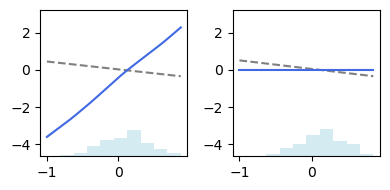

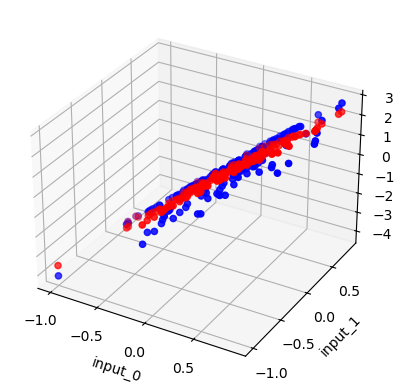

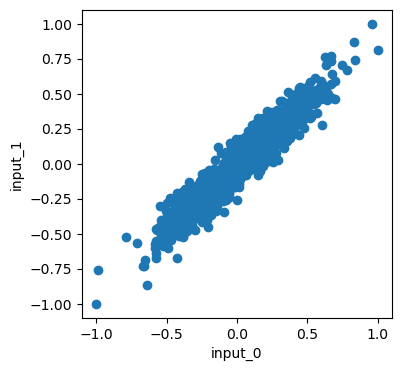

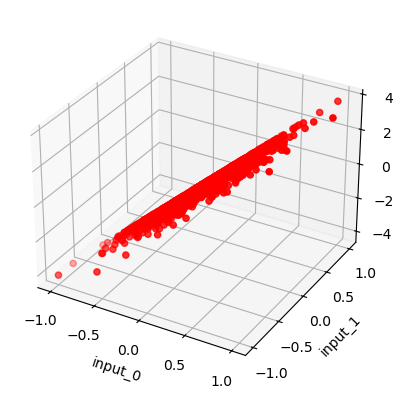

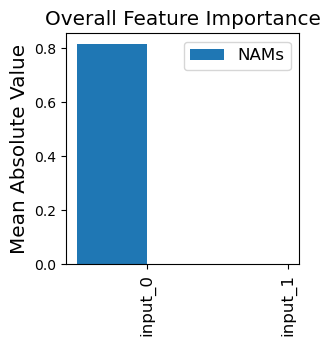

[Epoch=100, Train_RMSE:  0.096, Train_R_perp:  0.985, Val_RMSE:  0.042, Val_R_perp:  0.110, n_hypersteps=99]: observed noise= 0.056, prior precision=tensor([2.7668e+00, 2.9198e+03])
[Epoch=200, Train_RMSE:  0.096, Train_R_perp:  0.788, Val_RMSE:  0.036, Val_R_perp:  0.089, n_hypersteps=99]: observed noise= 0.055, prior precision=tensor([3.0501e+00, 8.7606e+03])
[Epoch=300, Train_RMSE:  0.093, Train_R_perp:  0.968, Val_RMSE:  0.034, Val_R_perp:  0.110, n_hypersteps=99]: observed noise= 0.054, prior precision=tensor([   3.3408, 3257.5598])
[Epoch=400, Train_RMSE:  0.094, Train_R_perp:  0.598, Val_RMSE:  0.039, Val_R_perp:  0.101, n_hypersteps=99]: observed noise= 0.054, prior precision=tensor([3.4823e+00, 9.5857e+03])
MARGLIK: finished training. Recover best model and fit Laplace.


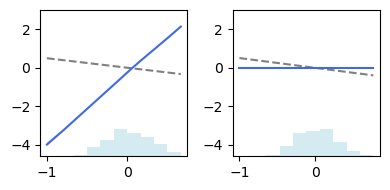

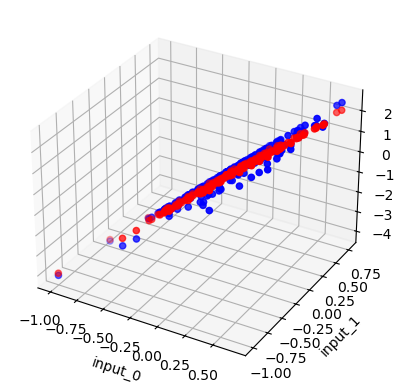

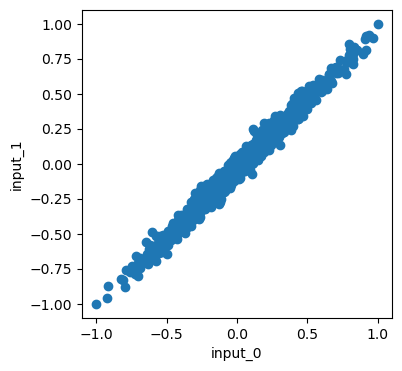

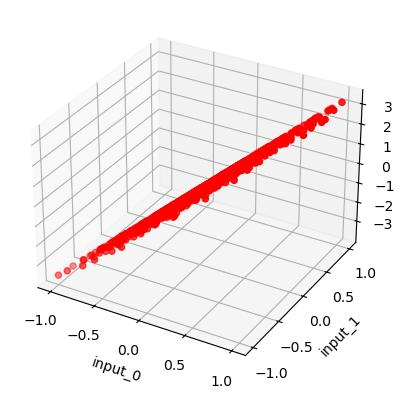

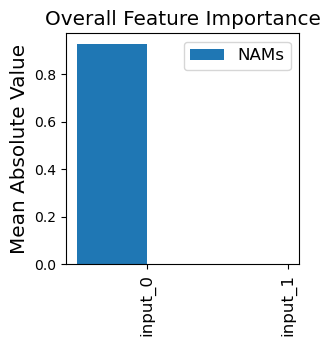

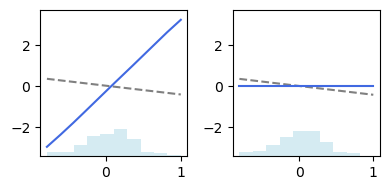

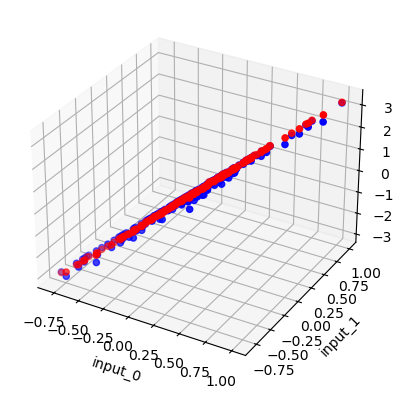

In [14]:
rhos=[0, 0.7, 0.9, 0.95, 0.99]
# rhos = [0.7]
lanam_cfg = defaults()
for rho in rhos: 
    data = generate_interaction_example(rho=rho)
    in_features = data.in_features
    train_dl, train_dl_fnn, val_dl, val_fnn = data.train_dataloaders()
    test_samples = data.get_test_samples()
    
    lanam = LaNAM(config=lanam_cfg, name="LA-NAM", in_features=in_features, hessian_structure='kron', subset_of_weights='last_layer')
    lanam, margs, losses, perfs = marglik_training(lanam, 
                                                   train_dl, 
                                                   train_dl_fnn, 
                                                   val_dl, 
                                                   likelihood='regression', 
                                                   test_samples=test_samples,
                                                   n_epochs=400, 
                                                   use_wandb=False, 
                                                   optimizer_kwargs={'lr': 1e-2}, 
                                                   log_loss_frequency=100, 
                                                   n_hypersteps=100, 
                                                   prior_prec_init=[1, 10], 
                                                  temperature=3)
    
    X, y, shape_functions, names = test_samples
    prediction_mean, feature_contribution_mean, prediction_mean, feature_contribution_var = get_prediction(lanam, test_samples)
    importance_fig = plot_feature_importance(lanam, test_samples)
    recover_fig = plot_recovered_functions(X, y, shape_functions, feature_contribution_mean, feature_contribution_var.flatten(start_dim=1), center=False)       
    # print(X.shape)
    plot_3d(X[:, 0], X[:, 1], prediction_mean, y)

[Epoch=100, Train_RMSE:  0.806, Train_R_perp:  0.022, Val_RMSE:  0.265, Val_R_perp:  0.000, n_hypersteps=99]: observed noise= 0.463, prior precision=tensor([  3.8028, 359.8857])
[Epoch=200, Train_RMSE:  0.806, Train_R_perp:  0.104, Val_RMSE:  0.265, Val_R_perp:  0.008, n_hypersteps=99]: observed noise= 0.465, prior precision=tensor([   3.6438, 2061.3167])
[Epoch=300, Train_RMSE:  0.806, Train_R_perp:  0.048, Val_RMSE:  0.265, Val_R_perp:  0.019, n_hypersteps=99]: observed noise= 0.465, prior precision=tensor([   3.5922, 2981.3645])
[Epoch=400, Train_RMSE:  0.805, Train_R_perp:  0.060, Val_RMSE:  0.265, Val_R_perp:  0.019, n_hypersteps=99]: observed noise= 0.465, prior precision=tensor([   3.4614, 3093.6194])
MARGLIK: finished training. Recover best model and fit Laplace.


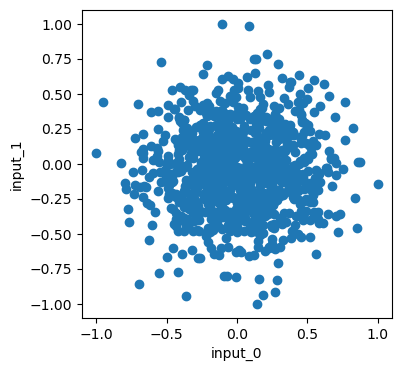

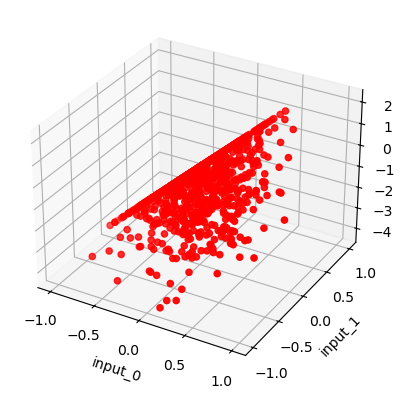

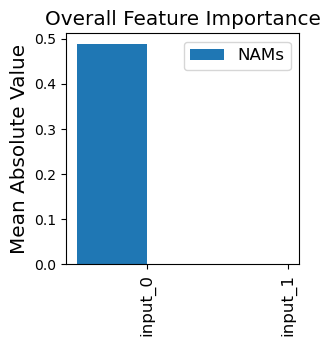

[Epoch=100, Train_RMSE:  0.535, Train_R_perp:  0.597, Val_RMSE:  0.218, Val_R_perp:  0.064, n_hypersteps=99]: observed noise= 0.311, prior precision=tensor([2.6883e+00, 3.5481e+03])
[Epoch=200, Train_RMSE:  0.525, Train_R_perp:  0.620, Val_RMSE:  0.210, Val_R_perp:  0.053, n_hypersteps=99]: observed noise= 0.303, prior precision=tensor([3.2560e+00, 4.0124e+03])
[Epoch=300, Train_RMSE:  0.528, Train_R_perp:  0.494, Val_RMSE:  0.212, Val_R_perp:  0.035, n_hypersteps=99]: observed noise= 0.305, prior precision=tensor([3.4062e+00, 3.4862e+03])
[Epoch=400, Train_RMSE:  0.525, Train_R_perp:  0.540, Val_RMSE:  0.212, Val_R_perp:  0.070, n_hypersteps=99]: observed noise= 0.303, prior precision=tensor([3.6051e+00, 4.2395e+03])
MARGLIK: finished training. Recover best model and fit Laplace.


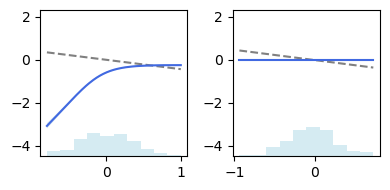

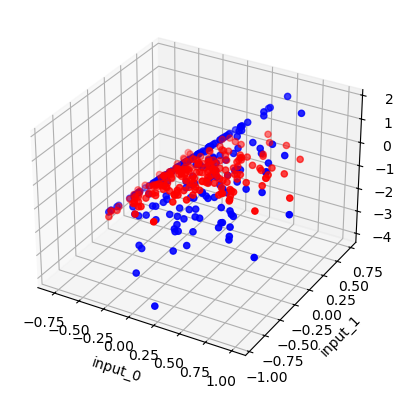

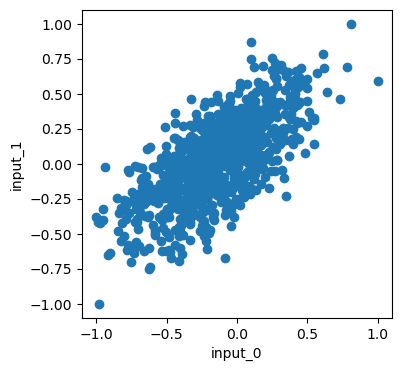

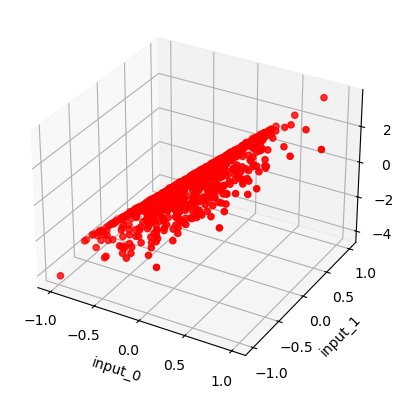

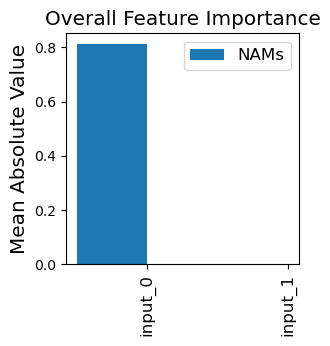

[Epoch=100, Train_RMSE:  0.282, Train_R_perp:  0.830, Val_RMSE:  0.112, Val_R_perp:  0.099, n_hypersteps=99]: observed noise= 0.161, prior precision=tensor([2.4008e+00, 4.9490e+03])
[Epoch=200, Train_RMSE:  0.281, Train_R_perp:  0.883, Val_RMSE:  0.111, Val_R_perp:  0.086, n_hypersteps=99]: observed noise= 0.162, prior precision=tensor([   2.8831, 2324.4990])
[Epoch=300, Train_RMSE:  0.282, Train_R_perp:  0.599, Val_RMSE:  0.110, Val_R_perp:  0.070, n_hypersteps=99]: observed noise= 0.163, prior precision=tensor([3.4837e+00, 5.5836e+03])
[Epoch=400, Train_RMSE:  0.282, Train_R_perp:  0.871, Val_RMSE:  0.113, Val_R_perp:  0.096, n_hypersteps=99]: observed noise= 0.163, prior precision=tensor([   3.7545, 3038.9028])
MARGLIK: finished training. Recover best model and fit Laplace.


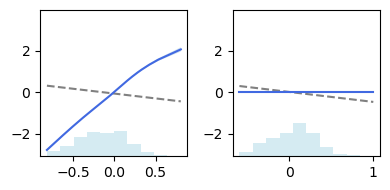

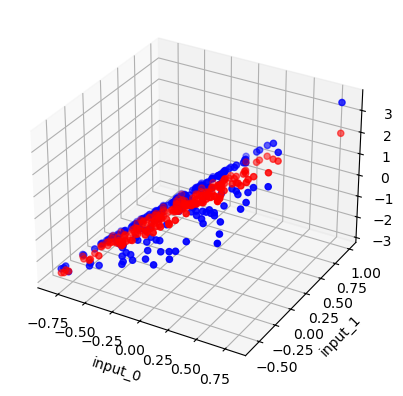

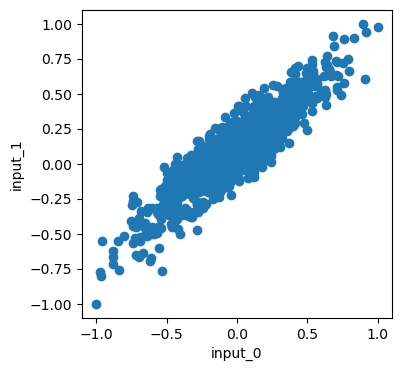

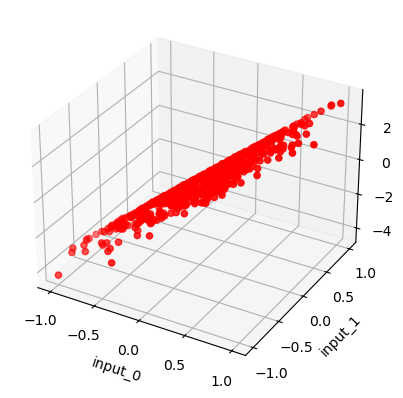

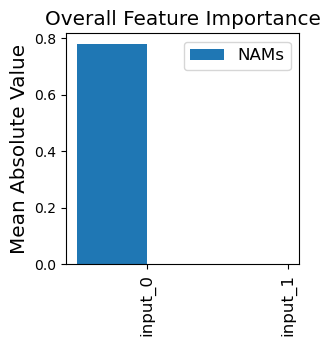

[Epoch=100, Train_RMSE:  0.229, Train_R_perp:  0.927, Val_RMSE:  0.063, Val_R_perp:  0.106, n_hypersteps=99]: observed noise= 0.131, prior precision=tensor([2.1622e+00, 4.9202e+03])
[Epoch=200, Train_RMSE:  0.236, Train_R_perp:  0.791, Val_RMSE:  0.061, Val_R_perp:  0.050, n_hypersteps=99]: observed noise= 0.136, prior precision=tensor([   2.7362, 2661.5994])
[Epoch=300, Train_RMSE:  0.230, Train_R_perp:  0.691, Val_RMSE:  0.061, Val_R_perp:  0.106, n_hypersteps=99]: observed noise= 0.133, prior precision=tensor([3.2201e+00, 4.2229e+03])
[Epoch=400, Train_RMSE:  0.228, Train_R_perp:  0.744, Val_RMSE:  0.061, Val_R_perp:  0.103, n_hypersteps=99]: observed noise= 0.132, prior precision=tensor([   3.4868, 3145.7278])
MARGLIK: finished training. Recover best model and fit Laplace.


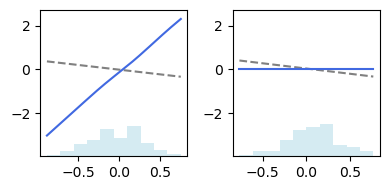

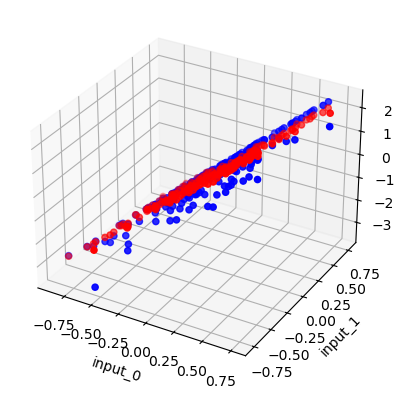

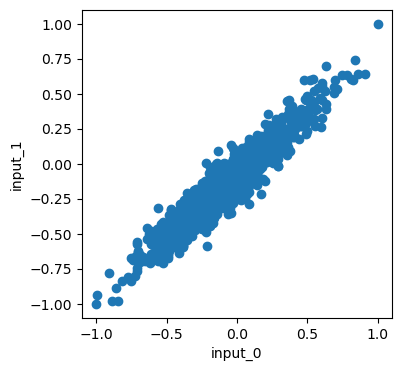

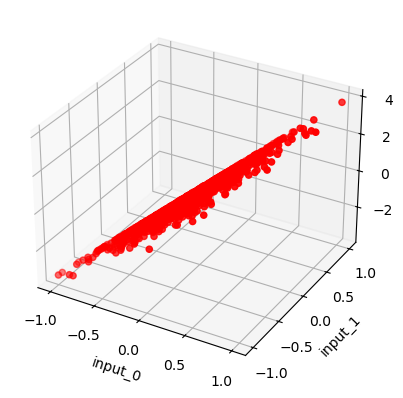

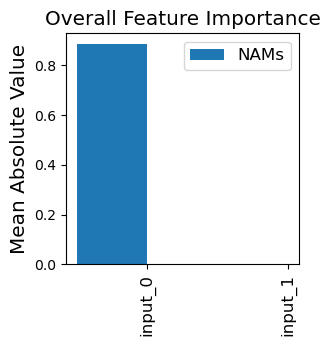

[Epoch=100, Train_RMSE:  0.111, Train_R_perp:  0.799, Val_RMSE:  0.030, Val_R_perp:  0.109, n_hypersteps=99]: observed noise= 0.065, prior precision=tensor([2.7428e+00, 5.1613e+03])
[Epoch=200, Train_RMSE:  0.102, Train_R_perp:  0.806, Val_RMSE:  0.030, Val_R_perp:  0.110, n_hypersteps=99]: observed noise= 0.059, prior precision=tensor([3.0762e+00, 4.0460e+03])
[Epoch=300, Train_RMSE:  0.103, Train_R_perp:  0.793, Val_RMSE:  0.030, Val_R_perp:  0.101, n_hypersteps=99]: observed noise= 0.059, prior precision=tensor([3.2789e+00, 7.3547e+03])
[Epoch=400, Train_RMSE:  0.108, Train_R_perp:  0.740, Val_RMSE:  0.030, Val_R_perp:  0.087, n_hypersteps=99]: observed noise= 0.062, prior precision=tensor([   3.3392, 3142.0071])
MARGLIK: finished training. Recover best model and fit Laplace.


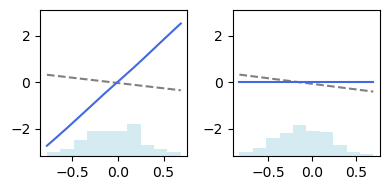

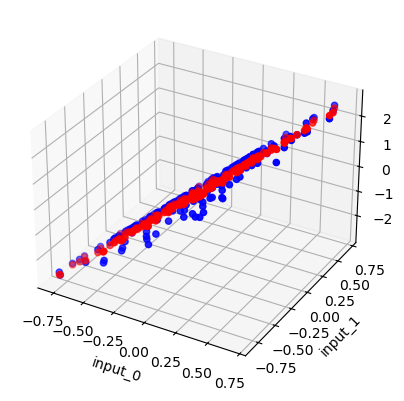

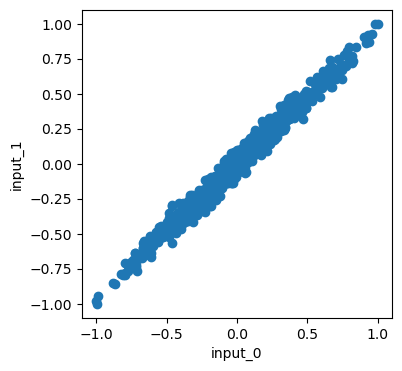

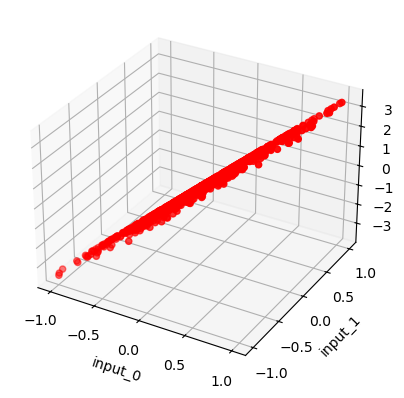

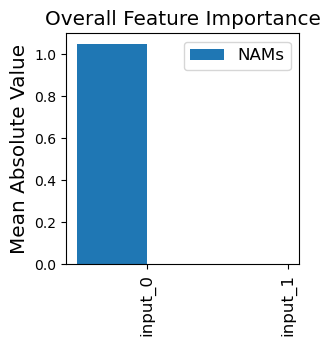

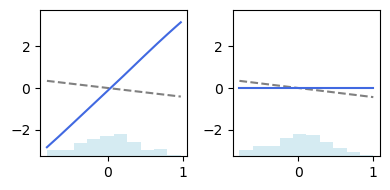

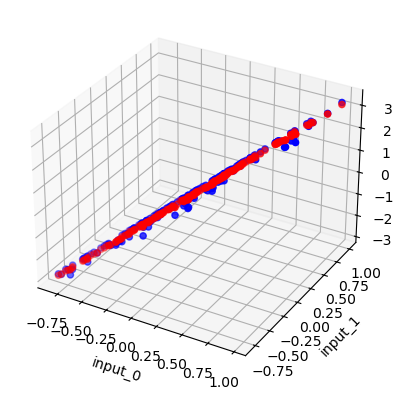

In [15]:
rhos=[0, 0.7, 0.9, 0.95, 0.99]
# rhos = [0.7]
lanam_cfg = defaults()
for rho in rhos: 
    data = generate_interaction_example(rho=rho)
    in_features = data.in_features
    train_dl, train_dl_fnn, val_dl, val_fnn = data.train_dataloaders()
    test_samples = data.get_test_samples()
    
    lanam = LaNAM(config=lanam_cfg, name="LA-NAM", in_features=in_features, hessian_structure='kron', subset_of_weights='last_layer')
    lanam, margs, losses, perfs = marglik_training(lanam, 
                                                   train_dl, 
                                                   train_dl_fnn, 
                                                   val_dl, 
                                                   likelihood='regression', 
                                                   test_samples=test_samples,
                                                   n_epochs=400, 
                                                   use_wandb=False, 
                                                   optimizer_kwargs={'lr': 1e-2}, 
                                                   log_loss_frequency=100, 
                                                   n_hypersteps=100, 
                                                   prior_prec_init=[1, 10], 
                                                  temperature=3)
    
    X, y, shape_functions, names = test_samples
    prediction_mean, feature_contribution_mean, prediction_mean, feature_contribution_var = get_prediction(lanam, test_samples)
    importance_fig = plot_feature_importance(lanam, test_samples)
    recover_fig = plot_recovered_functions(X, y, shape_functions, feature_contribution_mean, feature_contribution_var.flatten(start_dim=1), center=False)       
    # print(X.shape)
    plot_3d(X[:, 0], X[:, 1], prediction_mean, y)

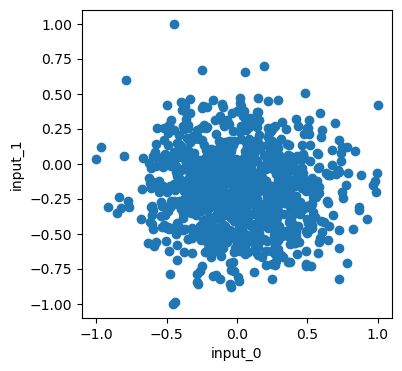

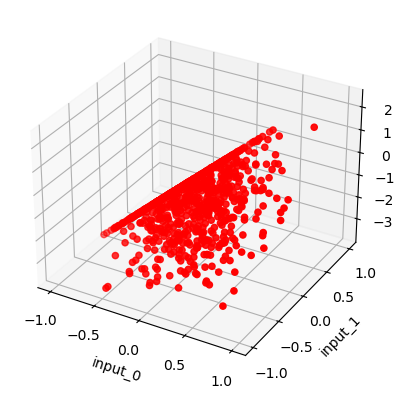

[EPOCH=30]: Train_Loss:  0.183214, Val_Loss:  0.151757,  Train_RMSE:  0.183214, Val_RMSE:  0.151757, Train_R_perp:  0.075640, Val_R_perp:  0.005849
[EPOCH=60]: Train_Loss:  0.177455, Val_Loss:  0.149902,  Train_RMSE:  0.177455, Val_RMSE:  0.149902, Train_R_perp:  0.044302, Val_R_perp:  0.014042
[EPOCH=81]: Early stopping with Val_Loss:  0.152665, Val_RMSE:  0.152665, Val_R_perp:  0.015475


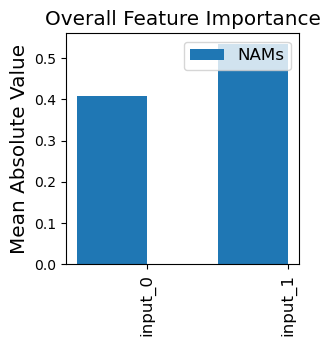

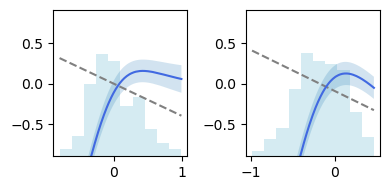

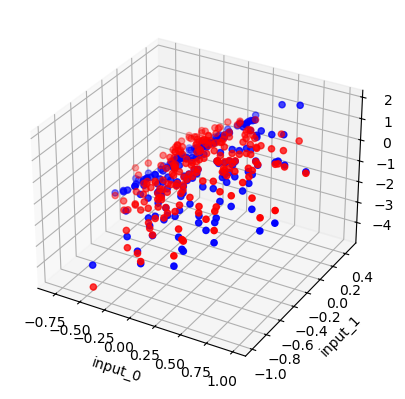

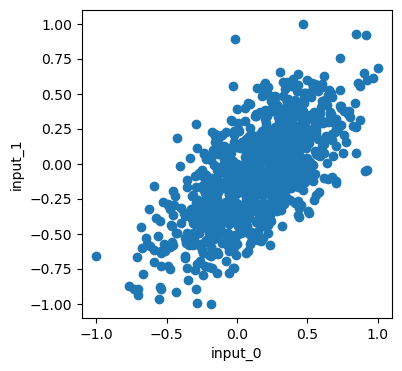

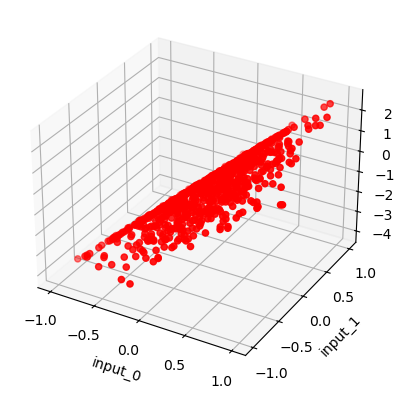

[EPOCH=30]: Early stopping with Val_Loss:  0.127751, Val_RMSE:  0.127751, Val_R_perp:  0.631625


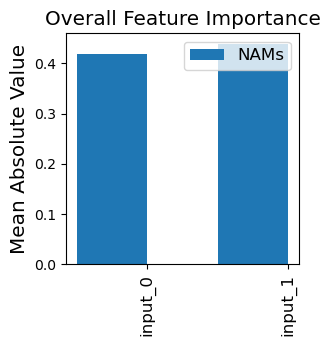

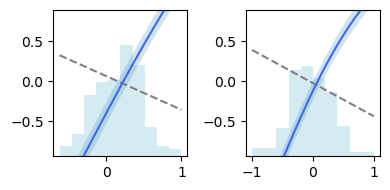

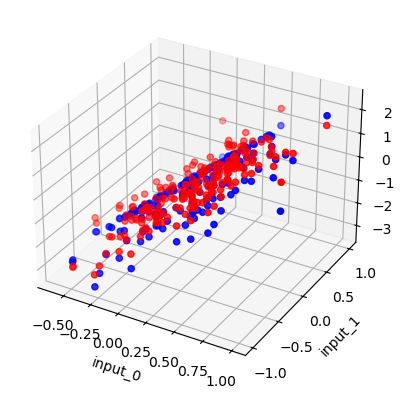

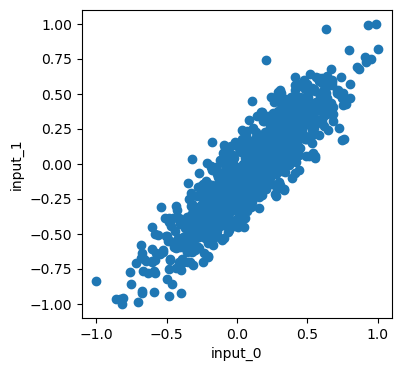

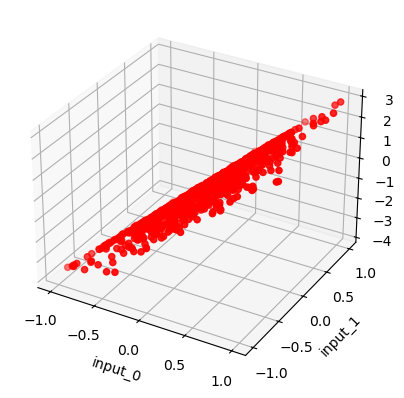

[EPOCH=30]: Train_Loss:  0.038033, Val_Loss:  0.044992,  Train_RMSE:  0.038033, Val_RMSE:  0.044992, Train_R_perp:  0.885105, Val_R_perp:  0.906032
[EPOCH=56]: Early stopping with Val_Loss:  0.045278, Val_RMSE:  0.045278, Val_R_perp:  0.905873


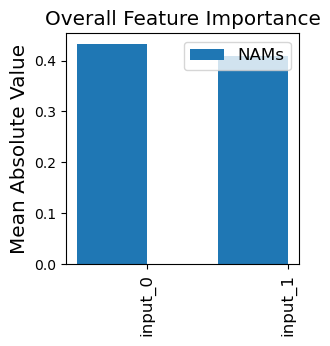

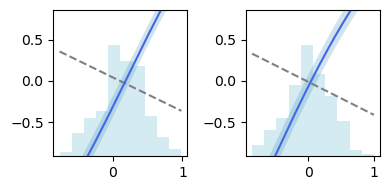

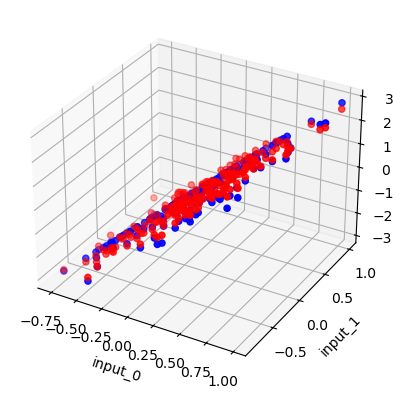

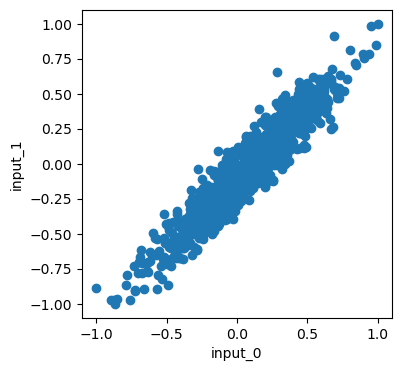

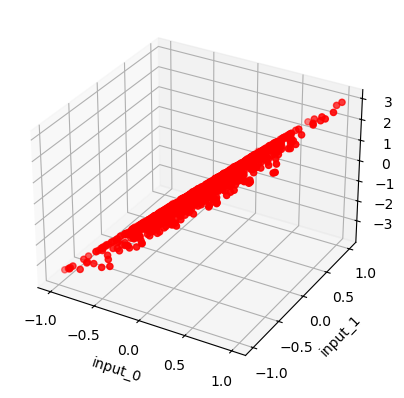

[EPOCH=30]: Train_Loss:  0.017917, Val_Loss:  0.024503,  Train_RMSE:  0.017917, Val_RMSE:  0.024503, Train_R_perp:  0.944702, Val_R_perp:  0.927845
[EPOCH=54]: Early stopping with Val_Loss:  0.023010, Val_RMSE:  0.023010, Val_R_perp:  0.926244


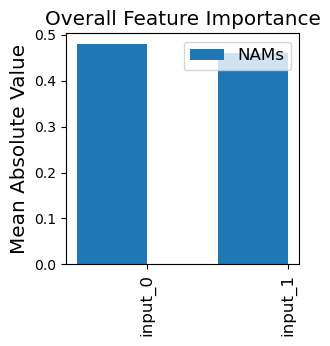

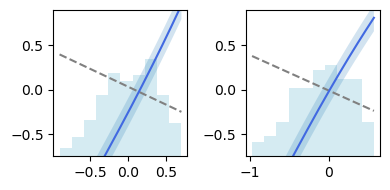

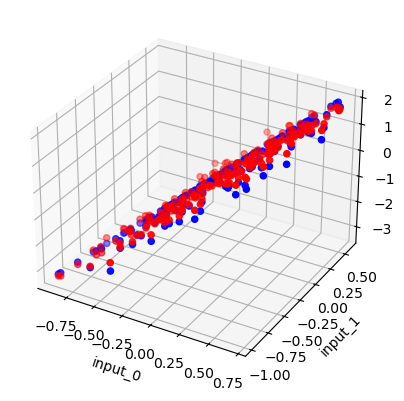

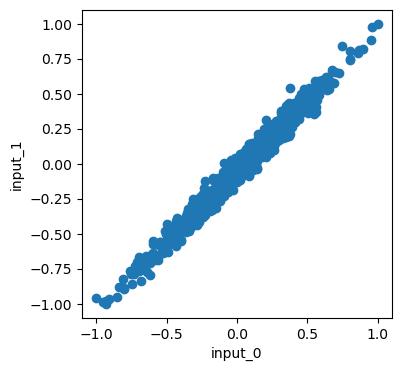

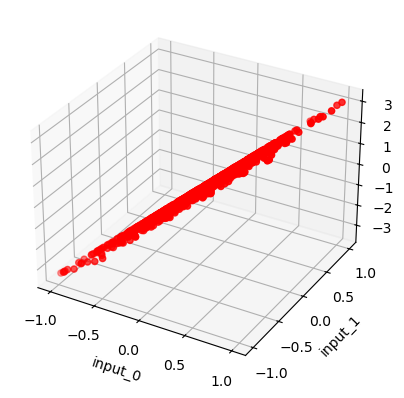

[EPOCH=30]: Train_Loss:  0.004061, Val_Loss:  0.003458,  Train_RMSE:  0.004061, Val_RMSE:  0.003458, Train_R_perp:  0.987755, Val_R_perp:  0.987893
[EPOCH=44]: Early stopping with Val_Loss:  0.003390, Val_RMSE:  0.003390, Val_R_perp:  0.987371


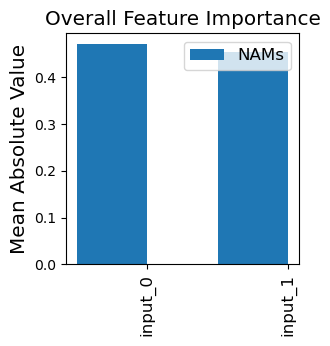

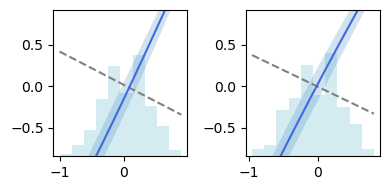

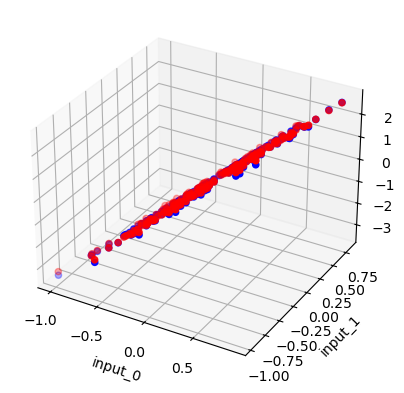

In [52]:
rhos=[0, 0.7, 0.9, 0.95, 0.99]
# rhos = [0.7]
nam_cfg = toy_default()
for rho in rhos: 
    data = generate_interaction_example(rho=rho)
    in_features = data.in_features
    train_dl, train_dl_fnn, val_dl, val_fnn = data.train_dataloaders()
    test_samples = data.get_test_samples()
    
    nam = train(config=nam_cfg, train_loader=train_dl, val_loader=val_dl, ensemble=True)
    
    X, y, shape_functions, names = test_samples
    prediction_mean, feature_contribution_mean, prediction_mean, feature_contribution_var = get_prediction(nam, test_samples)
    importance_fig = plot_feature_importance(nam, test_samples)
    recover_fig = plot_recovered_functions(X, y, shape_functions, feature_contribution_mean, feature_contribution_var.flatten(start_dim=1), center=False)       
    # print(X.shape)
    plot_3d(X[:, 0], X[:, 1], prediction_mean, y)

In [5]:
data = load_nonlinearly_dependent_2D_examples(num_samples=1000, dependent_functions=lambda x: torch.sin(3*x)) # uncorrelated features 
train_dl, train_fnn, val_dl, val_fnn = data.train_dataloaders()
test_samples = data.get_test_samples()

In [ ]:
cfg = toy_default()
cfg.log_loss_frequency = 600
cfg.concurvity_regularization = 0
namwo = train(config=cfg, train_loader=train_dl, val_loader=val_dl, test_samples=test_samples, ensemble=True)

In [ ]:
cfg = toy_default()
cfg.log_loss_frequency = 50
cfg.l2_regularization = 0.1
cfg.concurvity_regularization = 0
namwo = train(config=cfg, train_loader=train_dl, val_loader=val_dl, test_samples=test_samples, ensemble=True)

In [ ]:
cfg = toy_default()
cfg.log_loss_frequency = 100
cfg.l1_regularization = 0.005
cfg.concurvity_regularization = 0
namwo = train(config=cfg, train_loader=train_dl, val_loader=val_dl, test_samples=test_samples, ensemble=True)

In [ ]:
cfg.concurvity_regularization = 0.1
namw = train(config=cfg, train_loader=train_dl, val_loader=val_dl, test_samples=test_samples, ensemble=True)

In [16]:
cfg = defaults()
in_features = data.in_features
lanam = LaNAM(config=cfg, name="LA-NAM", in_features=in_features, hessian_structure='kron', subset_of_weights='last_layer')
lanamwo, margs, losses, perfs = marglik_training(lanam, 
                                                   train_dl, 
                                                   train_fnn, 
                                                   val_dl, 
                                                   likelihood='regression', 
                                                   test_samples=test_samples,
                                                   n_epochs=500, 
                                                   use_wandb=False, 
                                                   optimizer_kwargs={'lr': 1e-2}, 
                                                   concurvity_regularization=0)
    

[Epoch=100, MSE:  0.000, R_perp:  0.000, n_hypersteps=29]: additive sigma noise= 0.078
[Epoch=200, MSE:  0.000, R_perp:  0.000, n_hypersteps=29]: additive sigma noise= 0.004
[Epoch=300, MSE:  0.000, R_perp:  0.000, n_hypersteps=29]: additive sigma noise= 0.000
[Epoch=400, MSE:  0.000, R_perp:  0.000, n_hypersteps=29]: additive sigma noise= 0.001
[Epoch=500, MSE:  0.000, R_perp:  0.000, n_hypersteps=29]: additive sigma noise= 0.011
MARGLIK: finished training. Recover best model and fit Laplace.


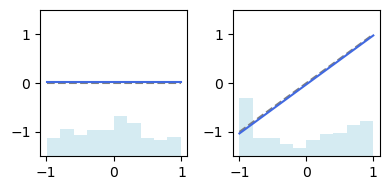

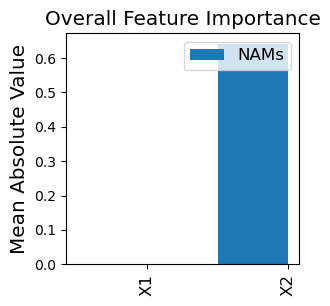

In [17]:
X, y, shape_functions, names = test_samples
prediction_mean, feature_contribution_mean, prediction_mean, feature_contribution_var = get_prediction(lanamwo, test_samples)
recover_fig = plot_recovered_functions(X, y, shape_functions, feature_contribution_mean, feature_contribution_var.flatten(start_dim=1), center=False)       
importance_fig = plot_feature_importance(lanamwo, test_samples)

### 2-Dimensional non-linearly dependent features
$$
\begin{aligned}
&Y = 0 \cdot X_1 + 1 \cdot X_2, \\
&X_1 =  Z, \\
&X_2 = |Z|, \\
&Z \sim \mathcal{N}(0, 1), \quad \text{truncated by } (-1, 1)
\end{aligned}
$$

In [4]:
data = load_nonlinearly_dependent_2D_examples(num_samples=1000) # uncorrelated features 
train_dl, train_fnn, val_dl, val_fnn = data.train_dataloaders()
test_samples = data.get_test_samples()

[EPOCH=492]: Early stopping with Val_Loss:  0.000000, Val_MSE:  0.000000, Val_R_perp:  0.972216


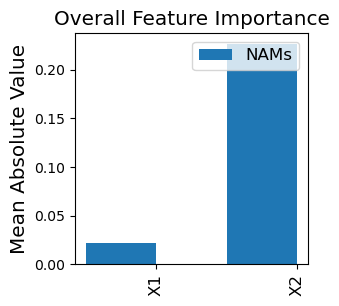

R_squared:  1.0000


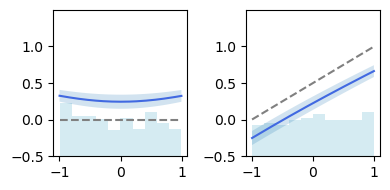

In [5]:
cfg = toy_default()
cfg.log_loss_frequency = 600
cfg.concurvity_regularization = 0
namwo = train(config=cfg, train_loader=train_dl, val_loader=val_dl, test_samples=test_samples, ensemble=True)

[EPOCH=83]: Early stopping with Val_Loss:  0.018871, Val_MSE:  0.000184, Val_R_perp:  0.186869


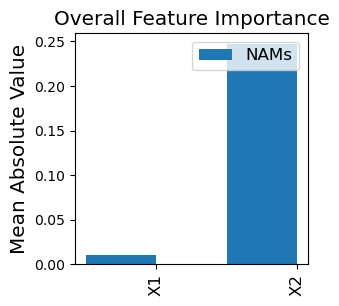

R_squared:  0.9980


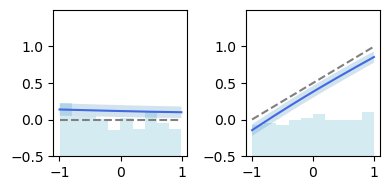

In [6]:
cfg.concurvity_regularization = 0.1
namw = train(config=cfg, train_loader=train_dl, val_loader=val_dl, test_samples=test_samples, ensemble=True)

In [7]:
cfg = defaults()
in_features = data.in_features
lanam = LaNAM(config=cfg, name="LA-NAM", in_features=in_features, hessian_structure='kron', subset_of_weights='last_layer')
lanamwo, margs, losses, perfs = marglik_training(lanam, 
                                                   train_dl, 
                                                   train_fnn, 
                                                   val_dl, 
                                                   likelihood='regression', 
                                                   test_samples=test_samples,
                                                   n_epochs=500, 
                                                   use_wandb=False, 
                                                   optimizer_kwargs={'lr': 1e-2}, 
                                                   concurvity_regularization=0)
    

[Epoch=100, MSE:  0.000, R_perp:  0.000, n_hypersteps=29]: additive sigma noise= 0.078
[Epoch=200, MSE:  0.000, R_perp:  0.000, n_hypersteps=29]: additive sigma noise= 0.004
[Epoch=300, MSE:  0.000, R_perp:  0.000, n_hypersteps=29]: additive sigma noise= 0.005
[Epoch=400, MSE:  0.000, R_perp:  0.000, n_hypersteps=29]: additive sigma noise= 0.001
[Epoch=500, MSE:  0.000, R_perp:  0.000, n_hypersteps=29]: additive sigma noise= 0.005
MARGLIK: finished training. Recover best model and fit Laplace.


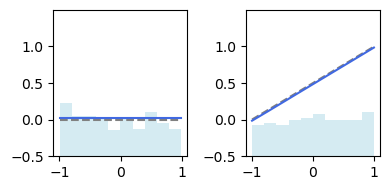

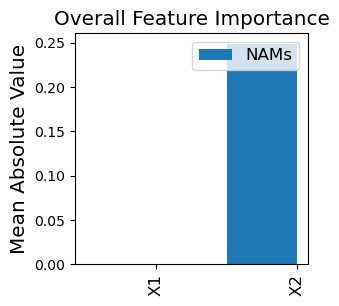

In [8]:
X, y, shape_functions, names = test_samples
prediction_mean, feature_contribution_mean, prediction_mean, feature_contribution_var = get_prediction(lanamwo, test_samples)
recover_fig = plot_recovered_functions(X, y, shape_functions, feature_contribution_mean, feature_contribution_var.flatten(start_dim=1), center=False)       
importance_fig = plot_feature_importance(lanamwo, test_samples)

In [11]:
cfg = defaults()
lanam = LaNAM(config=cfg, name="LA-NAM", in_features=in_features, hessian_structure='kron', subset_of_weights='last_layer')
lanamw, margs, losses, perfs = marglik_training(lanam, 
                                                   train_dl, 
                                                   train_fnn, 
                                                   val_dl, 
                                                   likelihood='regression', 
                                                   test_samples=test_samples,
                                                   n_epochs=500, 
                                                   use_wandb=False, 
                                                   optimizer_kwargs={'lr': 1e-2}, 
                                                   concurvity_regularization=0.1)
    

[Epoch=100, MSE:  0.000, R_perp:  0.066, n_hypersteps=29]: additive sigma noise= 0.078
[Epoch=200, MSE:  0.000, R_perp:  0.085, n_hypersteps=29]: additive sigma noise= 0.008
[Epoch=300, MSE:  0.000, R_perp:  0.095, n_hypersteps=29]: additive sigma noise= 0.009
[Epoch=400, MSE:  0.000, R_perp:  0.098, n_hypersteps=29]: additive sigma noise= 0.005
[Epoch=500, MSE:  0.000, R_perp:  0.077, n_hypersteps=29]: additive sigma noise= 0.016
MARGLIK: finished training. Recover best model and fit Laplace.


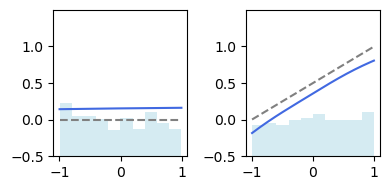

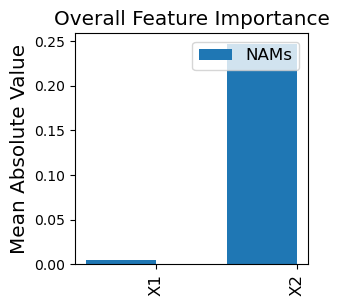

In [12]:
X, y, shape_functions, names = test_samples
prediction_mean, feature_contribution_mean, prediction_mean, feature_contribution_var = get_prediction(lanamw, test_samples)
recover_fig = plot_recovered_functions(X, y, shape_functions, feature_contribution_mean, feature_contribution_var.flatten(start_dim=1), center=False)       
importance_fig = plot_feature_importance(lanamw, test_samples)

### Concurvity examples
$$
X_1 \sim X_2 \sim X_3 \sim U(0,1)\\
X_4 = X_2^3 + X_3 ^ 2 + \sigma_1\\
X_5 = X_3^2+\sigma_1\\
X_6 = X_2^2 + X_4^3+\sigma_1 \\
X_7 = X_1 \times X_4 +\sigma_1\\
Y = 2X_1^2 + X_5^3 + 2\sin X_6+\sigma_2
$$

In [11]:
data = load_concurvity_data(sigma_1=0.05, sigma_2=0.5, num_samples=1000)
train_dl, train_dl_fnn, val_dl, val_dl_fnn = data.train_dataloaders()
test_dl, test_dl_fnn = data.test_dataloaders()
test_samples = data.get_test_samples()
in_features = data.in_features

torch.Size([1000, 7])


[EPOCH=30]: Train_Loss:  0.245716, Val_Loss:  0.263035,  Train_MSE:  0.245428, Val_MSE:  0.262754, Train_R_perp:  0.288018, Val_R_perp:  0.281947


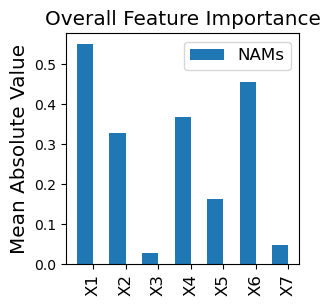

R_squared:  0.7775
[EPOCH=60]: Train_Loss:  0.236569, Val_Loss:  0.260544,  Train_MSE:  0.236303, Val_MSE:  0.260289, Train_R_perp:  0.266335, Val_R_perp:  0.255702


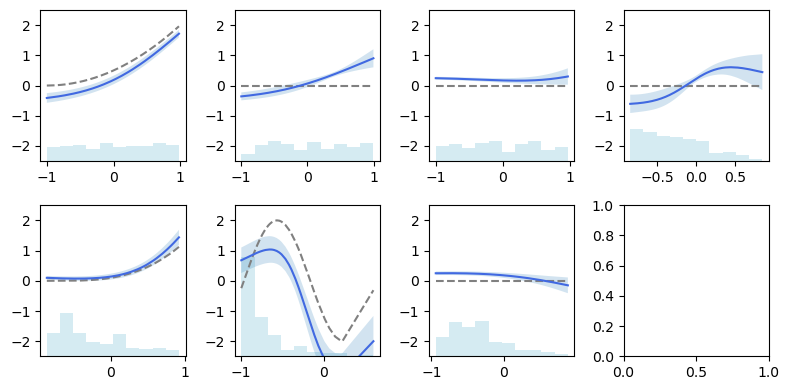

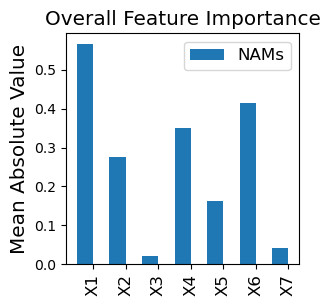

R_squared:  0.7815
[EPOCH=90]: Train_Loss:  0.236730, Val_Loss:  0.254467,  Train_MSE:  0.236495, Val_MSE:  0.254231, Train_R_perp:  0.234514, Val_R_perp:  0.236713


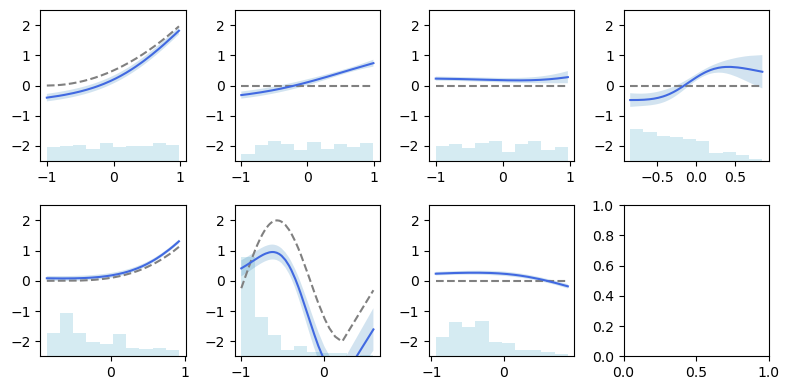

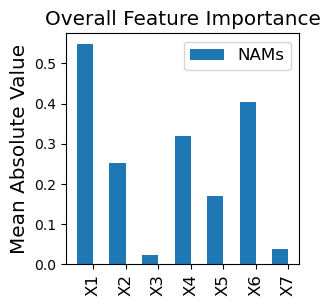

R_squared:  0.7832
[EPOCH=92]: Early stopping with Val_Loss:  0.252746, Val_MSE:  0.252515, Val_R_perp:  0.230988


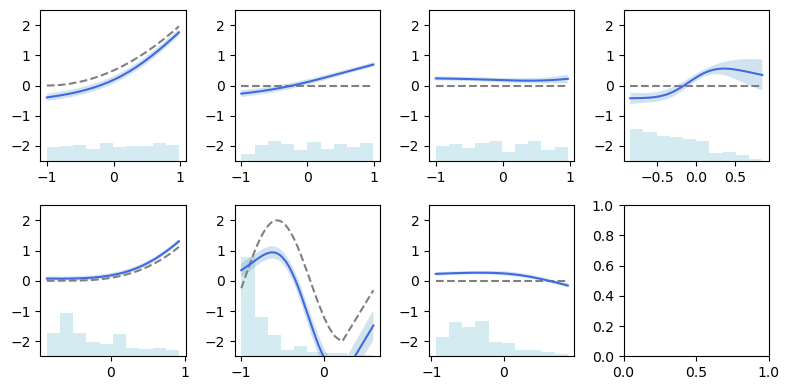

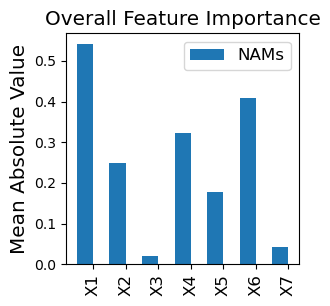

R_squared:  0.7830


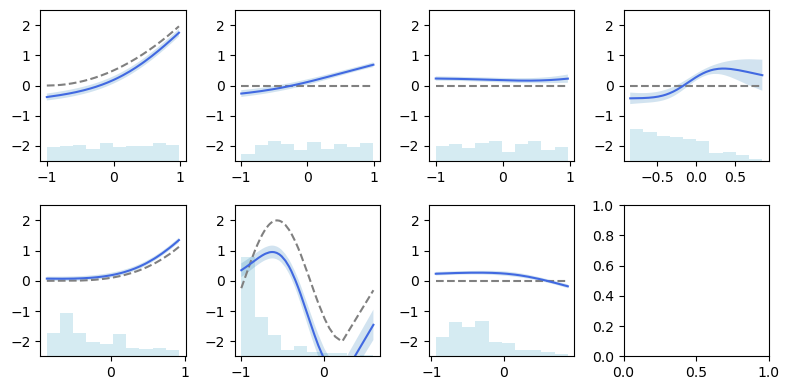

In [27]:
cfg = toy_default()
cfg.concurvity_regularization = 0.001
namw = train(config=cfg, train_loader=train_dl, val_loader=val_dl, test_samples=test_samples, ensemble=True)

[EPOCH=30]: Train_Loss:  0.245408, Val_Loss:  0.262761,  Train_MSE:  0.245408, Val_MSE:  0.262761, Train_R_perp:  0.289377, Val_R_perp:  0.283288


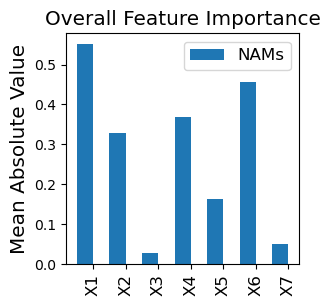

R_squared:  0.7775
[EPOCH=60]: Train_Loss:  0.236341, Val_Loss:  0.260070,  Train_MSE:  0.236341, Val_MSE:  0.260070, Train_R_perp:  0.282993, Val_R_perp:  0.273270


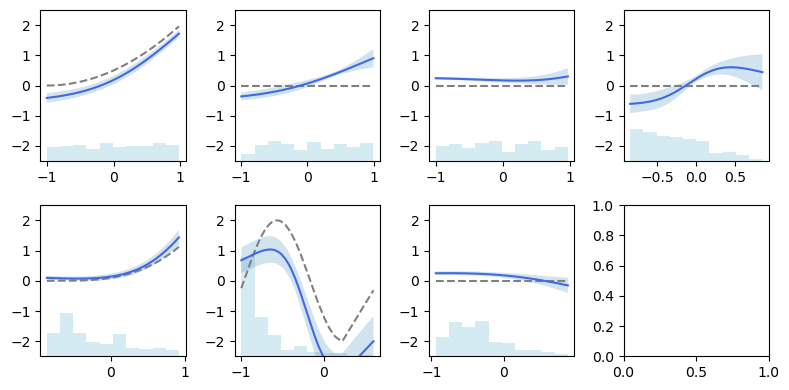

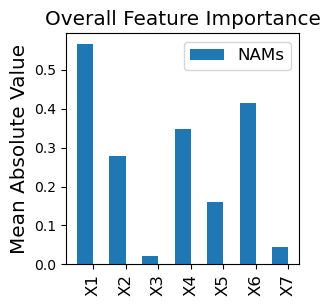

R_squared:  0.7816
[EPOCH=90]: Train_Loss:  0.236499, Val_Loss:  0.254115,  Train_MSE:  0.236499, Val_MSE:  0.254115, Train_R_perp:  0.242473, Val_R_perp:  0.240984


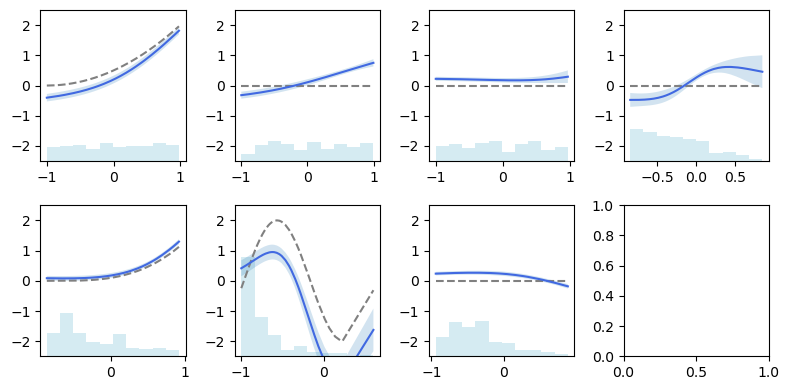

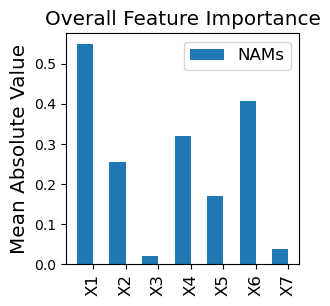

R_squared:  0.7832
[EPOCH=92]: Early stopping with Val_Loss:  0.252348, Val_MSE:  0.252348, Val_R_perp:  0.240162


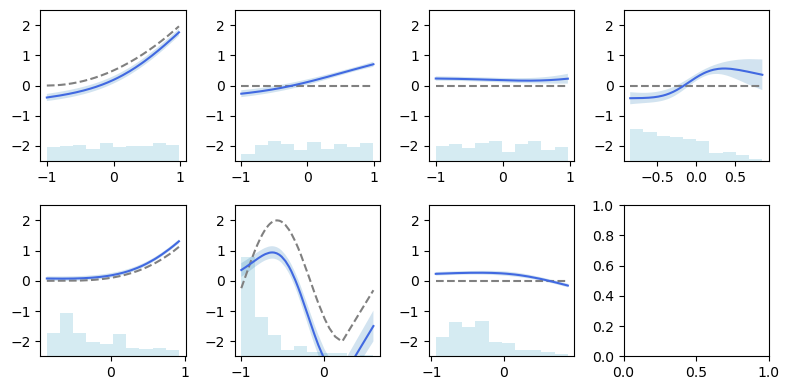

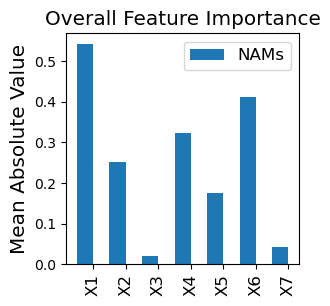

R_squared:  0.7830


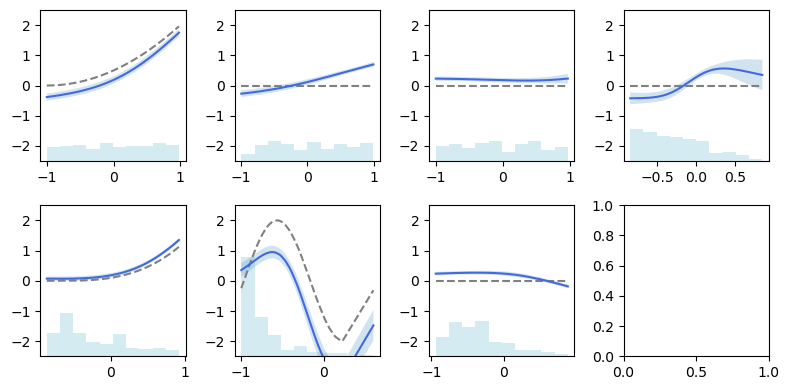

In [28]:
cfg = toy_default()
cfg.concurvity_regularization = 0
namw = train(config=cfg, train_loader=train_dl, val_loader=val_dl, test_samples=test_samples, ensemble=True)

In [ ]:
cfg = defaults()
lanam = LaNAM(config=cfg, name="LA-NAM", in_features=in_features, hessian_structure='kron', subset_of_weights='last_layer')
lanam, margs, losses, perfs = marglik_training(lanam, 
                                                   train_dl, 
                                                   train_dl_fnn, 
                                                   test_dl, 
                                                   likelihood='regression', 
                                                   test_samples=test_samples,
                                                   n_epochs=500, 
                                                   use_wandb=False, 
                                                   optimizer_kwargs={'lr': 1e-2}, 
                                                   concurvity_regularization=0, 
                                                  log_loss_frequency=20)
    

[Epoch=100, MSE:  0.256, R_perp:  0.287, n_hypersteps=29]: additive sigma noise= 0.435
[Epoch=200, MSE:  0.265, R_perp:  0.178, n_hypersteps=29]: additive sigma noise= 0.489
[Epoch=300, MSE:  0.237, R_perp:  0.031, n_hypersteps=29]: additive sigma noise= 0.487
[Epoch=400, MSE:  0.245, R_perp:  0.030, n_hypersteps=29]: additive sigma noise= 0.494


In [ ]:
X, y, shape_functions, names = test_samples
prediction_mean, feature_contribution_mean, prediction_mean, feature_contribution_var = get_prediction(lanam, test_samples)
recover_fig = plot_recovered_functions(X, y, shape_functions, feature_contribution_mean, feature_contribution_var.flatten(start_dim=1), center=False)       
importance_fig = plot_feature_importance(lanam, test_samples)

In [21]:
cfg = defaults()
w_lanam = LaNAM(config=cfg, name="LA-NAM", in_features=in_features, hessian_structure='kron', subset_of_weights='last_layer')
w_lanam, margs, losses, perfs = marglik_training(w_lanam, 
                                                   train_dl, 
                                                   train_dl_fnn, 
                                                   test_dl, 
                                                   likelihood='regression', 
                                                   test_samples=test_samples,
                                                   n_epochs=500, 
                                                   use_wandb=False, 
                                                   optimizer_kwargs={'lr': 1e-2}, 
                                                   concurvity_regularization=0.1, 
                                                  log_loss_frequency=20)
    

[Epoch=100, MSE:  0.250, R_perp:  0.200, n_hypersteps=29]: additive sigma noise= 0.427
[Epoch=200, MSE:  0.259, R_perp:  0.205, n_hypersteps=29]: additive sigma noise= 0.483
[Epoch=300, MSE:  0.241, R_perp:  0.214, n_hypersteps=29]: additive sigma noise= 0.489
[Epoch=400, MSE:  0.242, R_perp:  0.113, n_hypersteps=29]: additive sigma noise= 0.492
[Epoch=500, MSE:  0.274, R_perp:  0.095, n_hypersteps=29]: additive sigma noise= 0.519
MARGLIK: finished training. Recover best model and fit Laplace.


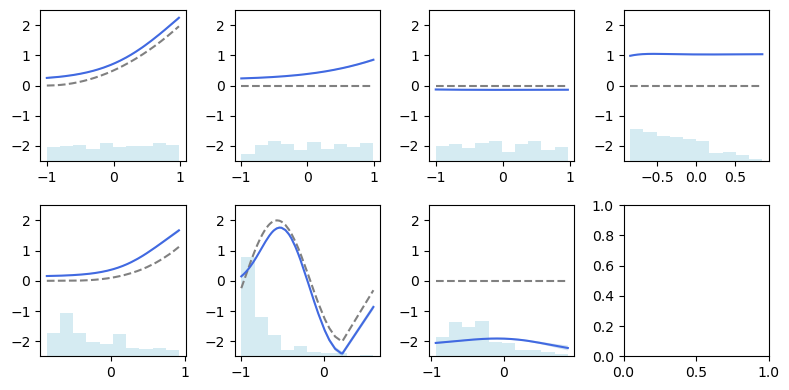

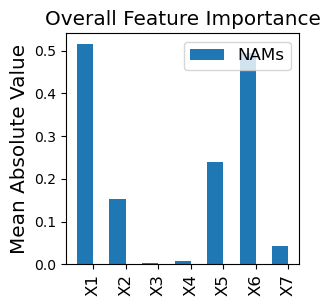

In [22]:
X, y, shape_functions, names = test_samples
prediction_mean, feature_contribution_mean, prediction_mean, feature_contribution_var = get_prediction(w_lanam, test_samples)
recover_fig = plot_recovered_functions(X, y, shape_functions, feature_contribution_mean, feature_contribution_var.flatten(start_dim=1), center=False)       
importance_fig = plot_feature_importance(w_lanam, test_samples)